In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
candles = pd.read_csv('../data/new/forecast_data/candles.csv')
print('candles', candles.shape)
# candles['begin'] = pd.to_datetime(candles['begin'])

candles_2 = pd.read_csv('../data/new/forecast_data/candles_2.csv')
print('candles_2', candles_2.shape)

news = pd.read_csv('../data/new/forecast_data/news.csv')
print('news', news.shape)

news_2 = pd.read_csv('../data/new/forecast_data/news_2.csv')
print('news_2', news_2.shape)

candles (24197, 7)
candles_2 (1745, 7)
news (25425, 4)
news_2 (2030, 3)


In [53]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# ---------------- Новости: лёгкая привязка к тикерам и per-ticker news_count ----------------
def build_ticker_aliases(tickers):
    base = {
        'AFLT': ['аэрофлот', 'aeroflot'],
        'ALRS': ['алроса', 'alrosa'],
        'CHMF': ['северсталь', 'severstal'],
        'GAZP': ['газпром', 'gazprom'],
        'GMKN': ['норникель', 'норильский никель', 'nornickel', 'norilsk nickel'],
        'LKOH': ['лукойл', 'lukoil'],
        'MAGN': ['ммк', 'магнитогорский металлургический комбинат', 'mmk'],
        'MGNT': ['магнит', 'magnit'],
        'MOEX': ['мосбиржа', 'московская биржа', 'moex'],
        'MTSS': ['мтс', 'mts'],
        'NVTK': ['новатэк', 'novatek'],
        'PHOR': ['фосагро', 'phosagro'],
        'PLZL': ['полюс', 'polyus'],
        'ROSN': ['роснефть', 'rosneft'],
        'RUAL': ['русал', 'rusal'],
        'SBER': ['сбер', 'сбербанк', 'sber', 'sberbank'],
        'SIBN': ['газпром нефть', 'gazprom neft'],
        'T':    ['тинькофф', 'т-банк', 'tinkoff', 't-bank'],
        'VTBR': ['втб', 'vtb'],
    }
    return {t: list(set(base.get(t, []) + [t.lower()])) for t in tickers}

def preprocess_sentiment_dummies(news_df):
    """Преобразуем sentiment в one-hot encoding"""
    df = news_df.copy()
    
    # Создаем dummy-переменные для sentiment
    if 'sentiment' in df.columns:
        sentiment_dummies = pd.get_dummies(df['sentiment'], prefix='sentiment')
        df = pd.concat([df, sentiment_dummies], axis=1)
    
    return df

def tag_news_with_tickers(news_df, ticker_aliases, text_cols=('title','publication')):
    news = news_df.copy()
    news['publish_date'] = pd.to_datetime(news['publish_date'])
    news = preprocess_sentiment_dummies(news)
    
    mentioned_cols = [col for col in news.columns if col.startswith('mentioned_')]
    
    if mentioned_cols:
        def get_mentioned_tickers(row):
            tickers_found = []
            for col in mentioned_cols:
                if row[col] == 1:
                    ticker = col.replace('mentioned_', '')
                    tickers_found.append(ticker)
            return tickers_found
        
        news['tickers'] = news.apply(get_mentioned_tickers, axis=1)
    else:
        news['_text'] = ''
        for c in text_cols:
            if c in news.columns:
                news['_text'] = (news['_text'] + ' ' + news[c].astype(str)).str.lower()
        
        def find_tickers(text):
            if not isinstance(text, str) or not text:
                return []
            found = []
            for tkr, keys in ticker_aliases.items():
                if any(k and k in text for k in keys):
                    found.append(tkr)
            return list(set(found))
        
        news['tickers'] = news['_text'].apply(find_tickers)
        news = news.drop(columns=['_text'])
    
    return news

#фичи новостей
def aggregate_news_features_by_ticker(news_tagged):
    df = news_tagged.copy()
    df['date'] = df['publish_date'].dt.normalize()
    exploded = df.explode('tickers')
    exploded = exploded[exploded['tickers'].notna() & (exploded['tickers']!='')]
    
    sentiment_cols = [col for col in exploded.columns if col.startswith('sentiment_')]
    
    aggregation_dict = {
        'title': 'count',
        'sentiment_confidence': 'mean',
        'emotional_score': 'mean',
        'has_financial_context': 'sum',
    }
    
    for col in sentiment_cols:
        aggregation_dict[col] = 'sum'
    
    agg = exploded.groupby(['tickers','date']).agg(aggregation_dict).reset_index()
    
    new_columns = ['ticker', 'date', 
                   'news_count',
                   'avg_sentiment_confidence', 'avg_emotional_score',
                   'financial_news_count']
    
    new_columns.extend(sentiment_cols)
    
    if len(agg.columns) != len(new_columns):
        print(f"Warning: Column count mismatch. Agg has {len(agg.columns)} cols, new_columns has {len(new_columns)}")
        print("Agg columns:", agg.columns.tolist())
        print("New columns:", new_columns)
        
        min_len = min(len(agg.columns), len(new_columns))
        agg.columns = new_columns[:min_len]
    else:
        agg.columns = new_columns
    
    agg['financial_news_ratio'] = agg['financial_news_count'] / agg['news_count']
    agg['financial_news_ratio'] = agg['financial_news_ratio'].fillna(0)
    
    for col in sentiment_cols:
        if col in agg.columns:
            ratio_col = f'{col}_ratio'
            agg[ratio_col] = agg[col] / agg['news_count']
            agg[ratio_col] = agg[ratio_col].fillna(0)
    
    return agg

def aggregate_news_counts_by_ticker(news_tagged):
    df = news_tagged.copy()
    df['date'] = df['publish_date'].dt.normalize()
    exploded = df.explode('tickers')
    exploded = exploded[exploded['tickers'].notna() & (exploded['tickers']!='')]
    agg = exploded.groupby(['tickers','date']).size().reset_index(name='news_count')
    agg = agg.rename(columns={'tickers':'ticker'})

    
    return agg

# добавление фичей
def add_news_features_by_ticker(candles_df, news_df, ticker_aliases):
    candles = candles_df.copy()
    candles['begin'] = pd.to_datetime(candles['begin'])
    candles['date'] = candles['begin'].dt.normalize()
    
    if news_df is None or len(news_df)==0:
        candles['news_count'] = 0.0
        candles['avg_sentiment_confidence'] = 0.0
        candles['avg_emotional_score'] = 0.0
        candles['financial_news_count'] = 0.0
        candles['financial_news_ratio'] = 0.0
        
        return candles.drop(columns=['date'])
    
    tagged = tag_news_with_tickers(news_df, ticker_aliases)
    news_features = aggregate_news_features_by_ticker(tagged)
    
    out = candles.merge(news_features, on=['ticker','date'], how='left')
    
    news_cols = [col for col in news_features.columns if col not in ['ticker', 'date']]
    
    for col in news_cols:
        out[col] = out[col].fillna(0.0)
    
    expected_sentiments = ['sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 'sentiment_mixed']
    for sent in expected_sentiments:
        if sent not in out.columns:
            out[sent] = 0.0
        if f'{sent}_ratio' not in out.columns:
            out[f'{sent}_ratio'] = 0.0
    
    return out.drop(columns=['date'])

    
    tagged = tag_news_with_tickers(news_df, ticker_aliases)
    news_features = aggregate_news_features_by_ticker(tagged)
    
    out = candles.merge(news_features, on=['ticker','date'], how='left') #лаг забыли учесть?
    
    news_cols = ['news_count', 'avg_sentiment', 'avg_sentiment_confidence', 
                 'avg_emotional_score', 'financial_news_count', 'sentiment_std', 
                 'max_sentiment', 'financial_news_ratio']
    
    for col in news_cols:
        out[col] = out[col].fillna(0.0)
    
    return out.drop(columns=['date'])

def add_news_count_by_ticker(candles_df, news_df, ticker_aliases):
    candles = candles_df.copy()
    candles['begin'] = pd.to_datetime(candles['begin'])
    candles['date'] = candles['begin'].dt.normalize()
    if news_df is None or len(news_df)==0:
        candles['news_count'] = 0.0
        return candles.drop(columns=['date'])
    tagged = tag_news_with_tickers(news_df, ticker_aliases)
    per_ticker = aggregate_news_counts_by_ticker(tagged)
    out = candles.merge(per_ticker, on=['ticker','date'], how='left')
    out['news_count'] = out['news_count'].fillna(0.0)
    return out.drop(columns=['date'])

# ---------------- Фичи и таргеты ----------------
# FEATS = ['momentum_5','volatility_5','price_range','news_count']
FEATS = [
    'momentum_5', 'volatility_5', 'price_range',
    'news_count', 'financial_news_count', 'financial_news_ratio',
    'avg_sentiment_confidence', 'avg_emotional_score',
    'sentiment_positive', 'sentiment_negative', 'sentiment_neutral', 'sentiment_mixed',
    'sentiment_positive_ratio', 'sentiment_negative_ratio', 'sentiment_neutral_ratio', 'sentiment_mixed_ratio'
]

def create_features(df):
    df = df.copy()
    df['begin'] = pd.to_datetime(df['begin'])
    df = df.sort_values(['ticker','begin']).reset_index(drop=True)
    df['momentum_5'] = df.groupby('ticker')['close'].pct_change(5)
    ret1 = df.groupby('ticker')['close'].pct_change()
    df['volatility_5'] = ret1.groupby(df['ticker']).rolling(5, min_periods=1).std().reset_index(level=0, drop=True)
    df['price_range'] = (df['high'] - df['low'])/df['close']
    
    for c in ['momentum_5','volatility_5','price_range']:
        df[c] = df[c].fillna(0.0)
    
    return df

def create_targets(df, horizons=(1,20)):
    out = df.copy()
    for h in horizons:
        out[f'target_return_{h}d'] = out.groupby('ticker')['close'].pct_change(h).shift(-h)
    return out

# ---------------- Обучение до отсечки ----------------
def fit(candles_train, news_train=None, split_date='2024-09-08', model_path='model.pkl'):
    df = candles_train.copy()
    df['begin'] = pd.to_datetime(df['begin'])
    cutoff = pd.to_datetime(split_date)
    df = df[df['begin']<=cutoff].copy()
    
    if len(df)==0:
        raise ValueError("Train slice after split_date is empty; adjust split_date or inputs.")
    
    aliases = build_ticker_aliases(sorted(df['ticker'].unique()))
    df = create_features(df)
    df = add_news_features_by_ticker(df, news_train, aliases)  # ← ИСПОЛЬЗУЕМ ОБНОВЛЕННУЮ ФУНКЦИЮ
    df = create_targets(df, horizons=(1,20))
    
    mask = ~df[[f'target_return_{h}d' for h in (1,20)]].isna().any(axis=1)
    dft = df.loc[mask].reset_index(drop=True)
    
    if len(dft)==0:
        raise ValueError("No valid rows with both targets h=1 and h=20 in train.")
    
    X = dft[FEATS].values
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    
    models = {}
    for h in (1,20):
        y = dft[f'target_return_{h}d'].values
        reg = LinearRegression().fit(Xs, y)
        models[f'reg_{h}'] = reg
    
    with open(model_path, 'wb') as f:
        pickle.dump({'features':FEATS,'scaler':scaler,'models':models,'aliases':aliases,'split_date':str(split_date)}, f)

# ---------------- Предсказание ровно на t = split_date (одна строка на тикер) ----------------
def _safe_write_csv(df, path):
    df.to_csv(path, index=False, sep=',', encoding='utf-8-sig', lineterminator='\n')  # совместимая запись CSV [web:159]

def predict_on_cutoff(candles_full, news_full=None, model_path='model.pkl', output_path='submission.csv'):
    with open(model_path, 'rb') as f:
        payload = pickle.load(f)
    feats   = payload['features']
    scaler  = payload['scaler']
    models  = payload['models']
    aliases = payload['aliases']
    split_date = pd.to_datetime(payload['split_date'])

    df = candles_full.copy()
    df['begin'] = pd.to_datetime(df['begin'])
    df_cut = df[df['begin']<=split_date].copy()  # предикт ровно на t ≤ split_date для каждого тикера
    if len(df_cut)==0:
        empty = pd.DataFrame(columns=['ticker'] + [f'p{i+1}' for i in range(20)])
        _safe_write_csv(empty, output_path)
        return empty

    df_cut = create_features(df_cut)
    df_cut = add_news_features_by_ticker(df_cut, news_full, aliases)

    last_idx = df_cut.groupby('ticker')['begin'].idxmax()
    dfl = df_cut.loc[last_idx].reset_index(drop=True)
    if len(dfl)==0:
        empty = pd.DataFrame(columns=['ticker'] + [f'p{i+1}' for i in range(20)])
        _safe_write_csv(empty, output_path)
        return empty

    Xs = scaler.transform(dfl[feats].values)
    pr1  = models['reg_1'].predict(Xs)
    pr20 = models['reg_20'].predict(Xs)

    alphas = np.linspace(0,1,20)[:,None]
    band = (1 - alphas)*pr1[None,:] + alphas*pr20[None,:]
    band = np.clip(band, -0.5, 0.5).T

    submission = pd.DataFrame({'ticker': dfl['ticker'].astype(str).fillna('')})
    for i in range(20):
        submission[f'p{i+1}'] = pd.to_numeric(band[:, i], errors='coerce')
    submission = submission.drop_duplicates(subset=['ticker'])
    nums = submission.drop(columns=['ticker']).replace([np.inf,-np.inf], np.nan).fillna(0.0).astype(float)
    submission.update(nums)
    submission = submission[['ticker'] + [f'p{i+1}' for i in range(20)]]
    _safe_write_csv(submission, output_path)
    return submission


In [54]:
def add_news_count_by_ticker(candles_df, news_df, ticker_aliases):
    candles = candles_df.copy()
    candles['begin'] = pd.to_datetime(candles['begin'])
    candles['date'] = candles['begin'].dt.normalize()
    if news_df is None or len(news_df)==0:
        candles['news_count'] = 0.0
        return candles.drop(columns=['date'])
    tagged = tag_news_with_tickers(news_df, ticker_aliases)
    per_ticker = aggregate_news_counts_by_ticker(tagged)
    out = candles.merge(per_ticker, on=['ticker','date'], how='left')
    out['news_count'] = out['news_count'].fillna(0.0)
    return out.drop(columns=['date'])

In [55]:
aliases = build_ticker_aliases(sorted(candles['ticker'].unique()))
df_nw = add_news_count_by_ticker(candles, news, aliases)

In [56]:
df_nw.head(2)

,open,close,high,low,volume,begin,ticker,news_count
0,81.50,81.7,83.20,81.16,29755530,2020-06-19,AFLT,1.0
1,81.72,82.1,83.98,80.26,18502950,2020-06-22,AFLT,1.0


In [57]:
news.head(2)

,Unnamed: 0,publish_date,title,publication
0,25389,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли. Ключевые российские нефте...
1,25388,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли. Ключевые российские стале...


In [58]:
news_features.columns

Index(['Unnamed: 0', 'publish_date', 'title', 'publication', 'tickers',
       'mentioned_AFLT', 'mentioned_ALRS', 'mentioned_GAZP', 'mentioned_LKOH',
       'mentioned_SBER', 'mentioned_ROSN', 'mentioned_GMKN', 'mentioned_MOEX',
       'mentioned_VTBR', 'mentioned_MGNT', 'mentioned_MTSS', 'mentioned_TATN',
       'mentioned_PHOR', 'mentioned_PLZL', 'mentioned_RUAL', 'mentioned_CHMF',
       'mentioned_NVTK', 'sentiment', 'sentiment_confidence',
       'emotional_score', 'analysis_method', 'has_financial_context'],
      dtype='object')

In [59]:
def preprocess_sentiment_dummies(news_df):
    """Преобразуем sentiment в one-hot encoding"""
    df = news_df.copy()
    
    if 'sentiment' in df.columns:
        sentiment_dummies = pd.get_dummies(df['sentiment'], prefix='sentiment') 
        df = pd.concat([df, sentiment_dummies], axis=1)
    
    return df

In [60]:
news_features.columns

Index(['Unnamed: 0', 'publish_date', 'title', 'publication', 'tickers',
       'mentioned_AFLT', 'mentioned_ALRS', 'mentioned_GAZP', 'mentioned_LKOH',
       'mentioned_SBER', 'mentioned_ROSN', 'mentioned_GMKN', 'mentioned_MOEX',
       'mentioned_VTBR', 'mentioned_MGNT', 'mentioned_MTSS', 'mentioned_TATN',
       'mentioned_PHOR', 'mentioned_PLZL', 'mentioned_RUAL', 'mentioned_CHMF',
       'mentioned_NVTK', 'sentiment', 'sentiment_confidence',
       'emotional_score', 'analysis_method', 'has_financial_context'],
      dtype='object')

In [61]:
news_features = pd.read_parquet('news_features.parquet')
# news_features = preprocess_sentiment_dummies(news_features).drop(['sentiment', 'analysis_method'], axis=1)
print(news_features.shape)
news_features.head(2)

(25425, 27)


,Unnamed: 0,publish_date,title,publication,tickers,mentioned_AFLT,mentioned_ALRS,mentioned_GAZP,mentioned_LKOH,mentioned_SBER,...,mentioned_PHOR,mentioned_PLZL,mentioned_RUAL,mentioned_CHMF,mentioned_NVTK,sentiment,sentiment_confidence,emotional_score,analysis_method,has_financial_context
0,25389,2020-01-01 14:00:00,Ключевые российские нефтегазовые компании смот...,Тенденции в отрасли. Ключевые российские нефте...,"[GAZP, TATN, ROSN]",False,False,True,False,False,...,False,False,False,False,False,positive,0.95,0.511278,improved_financial,True
1,25388,2020-01-02 15:00:00,ММК выгодно отличает высокая экспозиция на вну...,Тенденции в отрасли. Ключевые российские стале...,[],False,False,False,False,False,...,False,False,False,False,False,positive,0.95,0.411111,improved_financial,True


In [ ]:
fit(candles, news_features, split_date='2024-09-08', model_path='model.pkl')
predict_on_cutoff(candles, news_features, model_path='model.pkl', output_path='submission.csv')


Agg columns: ['tickers', 'date', 'title', 'sentiment_confidence', 'emotional_score', 'has_financial_context', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive']
New columns: ['ticker', 'date', 'news_count', 'avg_sentiment_confidence', 'avg_emotional_score', 'financial_news_count', 'sentiment_confidence', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive']
Agg columns: ['tickers', 'date', 'title', 'sentiment_confidence', 'emotional_score', 'has_financial_context', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive']
New columns: ['ticker', 'date', 'news_count', 'avg_sentiment_confidence', 'avg_emotional_score', 'financial_news_count', 'sentiment_confidence', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive']


,ticker,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20
0,AFLT,0.000358,0.000562,0.000767,0.000971,0.001176,0.001380,0.001585,0.001789,0.001993,...,0.002402,0.002607,0.002811,0.003016,0.003220,0.003425,0.003629,0.003834,0.004038,0.004242
1,ALRS,0.000423,0.000563,0.000704,0.000844,0.000984,0.001125,0.001265,0.001405,0.001546,...,0.001826,0.001967,0.002107,0.002247,0.002388,0.002528,0.002668,0.002809,0.002949,0.003089
2,CHMF,0.000456,0.000749,0.001042,0.001335,0.001629,0.001922,0.002215,0.002509,0.002802,...,0.003388,0.003682,0.003975,0.004268,0.004562,0.004855,0.005148,0.005441,0.005735,0.006028
3,GAZP,0.000417,0.001018,0.001619,0.002220,0.002821,0.003423,0.004024,0.004625,0.005226,...,0.006428,0.007030,0.007631,0.008232,0.008833,0.009434,0.010036,0.010637,0.011238,0.011839
4,GMKN,-0.000230,0.000181,0.000593,0.001004,0.001415,0.001826,0.002237,0.002648,0.003060,...,0.003882,0.004293,0.004704,0.005115,0.005527,0.005938,0.006349,0.006760,0.007171,0.007582
5,LKOH,0.001286,0.001951,0.002616,0.003280,0.003945,0.004610,0.005274,0.005939,0.006604,...,0.007933,0.008598,0.009263,0.009928,0.010592,0.011257,0.011922,0.012587,0.013251,0.013916
6,MAGN,-0.000200,0.000280,0.000760,0.001240,0.001720,0.002200,0.002679,0.003159,0.003639,...,0.004599,0.005079,0.005559,0.006039,0.006519,0.006998,0.007478,0.007958,0.008438,0.008918
7,MGNT,0.000496,0.000650,0.000803,0.000956,0.001109,0.001263,0.001416,0.001569,0.001723,...,0.002029,0.002182,0.002336,0.002489,0.002642,0.002796,0.002949,0.003102,0.003255,0.003409
8,MOEX,-0.000068,0.000306,0.000680,0.001053,0.001427,0.001801,0.002175,0.002549,0.002922,...,0.003670,0.004044,0.004417,0.004791,0.005165,0.005539,0.005913,0.006286,0.006660,0.007034
9,MTSS,0.000440,0.000988,0.001536,0.002084,0.002632,0.003180,0.003728,0.004276,0.004825,...,0.005921,0.006469,0.007017,0.007565,0.008113,0.008661,0.009210,0.009758,0.010306,0.010854


# оцениваем

In [64]:
def prepare_evaluation_data(candles_df, predictions_df, split_date):
    """
    Подготавливает данные для оценки: объединяет предсказания с фактическими ценами
    """
    candles = candles_df.copy()
    predictions = predictions_df.copy()
    
    candles['begin'] = pd.to_datetime(candles['begin'])
    split_date = pd.to_datetime(split_date)
    
    evaluation_data = []
    
    for _, pred_row in predictions.iterrows():
        ticker = pred_row['ticker']
        
        base_price = candles[
            (candles['ticker'] == ticker) & 
            (candles['begin'] <= split_date)
        ].sort_values('begin').iloc[-1]['close']
        
        for horizon in range(1, 21):
            pred_col = f'p{horizon}'
            predicted_return = pred_row[pred_col]
            predicted_price = base_price * (1 + predicted_return)
            
            target_date = split_date + pd.Timedelta(days=horizon)
            actual_data = candles[
                (candles['ticker'] == ticker) & 
                (candles['begin'] > split_date) &
                (candles['begin'] <= target_date)
            ]
            
            if len(actual_data) > 0:
                actual_price = actual_data.sort_values('begin').iloc[-1]['close']
                actual_return = (actual_price - base_price) / base_price
                
                evaluation_data.append({
                    'ticker': ticker,
                    'horizon': horizon,
                    'predicted_return': predicted_return,
                    'actual_return': actual_return,
                    'predicted_price': predicted_price,
                    'actual_price': actual_price,
                    'base_price': base_price
                })
    
    return pd.DataFrame(evaluation_data)

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def calculate_metrics(evaluation_df):
    """
    Вычисляет все метрики качества прогнозирования
    """
    results = {}
    
    actual_returns = evaluation_df['actual_return']
    predicted_returns = evaluation_df['predicted_return']
    
    results['mse_return'] = mean_squared_error(actual_returns, predicted_returns)
    results['rmse_return'] = np.sqrt(results['mse_return'])
    results['mae_return'] = mean_absolute_error(actual_returns, predicted_returns)
    results['r2_return'] = r2_score(actual_returns, predicted_returns)
    
    direction_correct = ((actual_returns * predicted_returns) > 0) | ((actual_returns == 0) & (predicted_returns == 0))
    results['direction_accuracy'] = direction_correct.mean()
    
    actual_prices = evaluation_df['actual_price']
    predicted_prices = evaluation_df['predicted_price']
    
    results['mse_price'] = mean_squared_error(actual_prices, predicted_prices)
    results['rmse_price'] = np.sqrt(results['mse_price'])
    results['mape_price'] = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
    
    return results

def calculate_metrics_by_horizon(evaluation_df):
    """
    Вычисляет метрики для каждого горизонта прогноза отдельно
    """
    horizons = sorted(evaluation_df['horizon'].unique())
    horizon_metrics = {}
    
    for horizon in horizons:
        horizon_data = evaluation_df[evaluation_df['horizon'] == horizon]
        
        metrics = {
            'mse': mean_squared_error(horizon_data['actual_return'], horizon_data['predicted_return']),
            'mae': mean_absolute_error(horizon_data['actual_return'], horizon_data['predicted_return']),
            'direction_accuracy': ((horizon_data['actual_return'] * horizon_data['predicted_return']) > 0).mean(),
            'count': len(horizon_data)
        }
        horizon_metrics[horizon] = metrics
    
    return horizon_metrics

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(evaluation_df, ticker=None):
    """
    Визуализация предсказаний vs факт
    """
    if ticker:
        data = evaluation_df[evaluation_df['ticker'] == ticker]
        title_suffix = f' - {ticker}'
    else:
        data = evaluation_df
        title_suffix = ' - Все тикеры'
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data['predicted_return'], data['actual_return'], alpha=0.6)
    plt.plot([data['actual_return'].min(), data['actual_return'].max()], 
             [data['actual_return'].min(), data['actual_return'].max()], 'r--')
    plt.xlabel('Предсказанная доходность')
    plt.ylabel('Фактическая доходность')
    plt.title(f'Предсказания vs Факт{title_suffix}')
    
    plt.subplot(1, 3, 2)
    horizon_metrics = calculate_metrics_by_horizon(data)
    horizons = list(horizon_metrics.keys())
    mae_values = [horizon_metrics[h]['mae'] for h in horizons]
    plt.plot(horizons, mae_values, 'o-')
    plt.xlabel('Горизонт прогноза (дни)')
    plt.ylabel('MAE')
    plt.title('Ошибка по горизонтам')
    
    plt.subplot(1, 3, 3)
    direction_acc = [horizon_metrics[h]['direction_accuracy'] for h in horizons]
    plt.plot(horizons, direction_acc, 'o-', color='green')
    plt.xlabel('Горизонт прогноза (дни)')
    plt.ylabel('Точность направления')
    plt.title('Точность направления')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def print_detailed_metrics(evaluation_df):
    """
    Выводит детальную статистику по метрикам
    """
    overall_metrics = calculate_metrics(evaluation_df)
    horizon_metrics = calculate_metrics_by_horizon(evaluation_df)
    
    print("=" * 50)
    print("ОБЩИЕ МЕТРИКИ КАЧЕСТВА:")
    print("=" * 50)
    print(f"RMSE доходности: {overall_metrics['rmse_return']:.6f}")
    print(f"MAE доходности: {overall_metrics['mae_return']:.6f}")
    print(f"R² доходности: {overall_metrics['r2_return']:.4f}")
    print(f"Точность направления: {overall_metrics['direction_accuracy']:.2%}")
    print(f"MAPE цены: {overall_metrics['mape_price']:.2f}%")
    
    print("\n" + "=" * 50)
    print("МЕТРИКИ ПО ГОРИЗОНТАМ:")
    print("=" * 50)
    for horizon in sorted(horizon_metrics.keys()):
        metrics = horizon_metrics[horizon]
        print(f"Горизонт {horizon:2d}д: MAE={metrics['mae']:.6f}, "
              f"Направление={metrics['direction_accuracy']:.2%}, "
              f"n={metrics['count']}")

In [70]:
def predict_and_save(candles_full, news_full=None, model_path='model.pkl', 
                    predictions_path='predictions.csv', output_path='submission.csv'):
    
    predictions = predict_on_cutoff(candles_full, news_full, model_path, output_path)
    
    # Сохраняем предсказания для последующей оценки
    predictions.to_csv(predictions_path, index=False)
    print(f"Предсказания сохранены в {predictions_path}")
    
    return predictions

submission = predict_and_save(candles, news_features, model_path='model.pkl',
                             predictions_path='predictions.csv',
                             output_path='submission.csv')

Agg columns: ['tickers', 'date', 'title', 'sentiment_confidence', 'emotional_score', 'has_financial_context', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive']
New columns: ['ticker', 'date', 'news_count', 'avg_sentiment_confidence', 'avg_emotional_score', 'financial_news_count', 'sentiment_confidence', 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive']
Предсказания сохранены в predictions.csv


RMSE доходности: 0.068610
MAE доходности: 0.052259
R² доходности: -0.8176
Точность направления: 80.79%
MAPE цены: 4.80%

ОБЩИЕ МЕТРИКИ КАЧЕСТВА:
RMSE доходности: 0.068610
MAE доходности: 0.052259
R² доходности: -0.8176
Точность направления: 80.79%
MAPE цены: 4.80%

МЕТРИКИ ПО ГОРИЗОНТАМ:
Горизонт  1д: MAE=0.030175, Направление=73.68%, n=19
Горизонт  2д: MAE=0.016369, Направление=73.68%, n=19
Горизонт  3д: MAE=0.015307, Направление=47.37%, n=19
Горизонт  4д: MAE=0.019010, Направление=47.37%, n=19
Горизонт  5д: MAE=0.023387, Направление=63.16%, n=19
Горизонт  6д: MAE=0.023206, Направление=63.16%, n=19
Горизонт  7д: MAE=0.023025, Направление=63.16%, n=19
Горизонт  8д: MAE=0.041770, Направление=84.21%, n=19
Горизонт  9д: MAE=0.058612, Направление=89.47%, n=19
Горизонт 10д: MAE=0.045142, Направление=84.21%, n=19
Горизонт 11д: MAE=0.052343, Направление=89.47%, n=19
Горизонт 12д: MAE=0.067043, Направление=89.47%, n=19
Горизонт 13д: MAE=0.066736, Направление=89.47%, n=19
Горизонт 14д: MAE=0.066430, Направление=89.47%, n=19
Горизонт 15д: MAE=0.079169, Направление=94.74%, n=19
Горизонт 16д: MAE=0.090252, Направлен

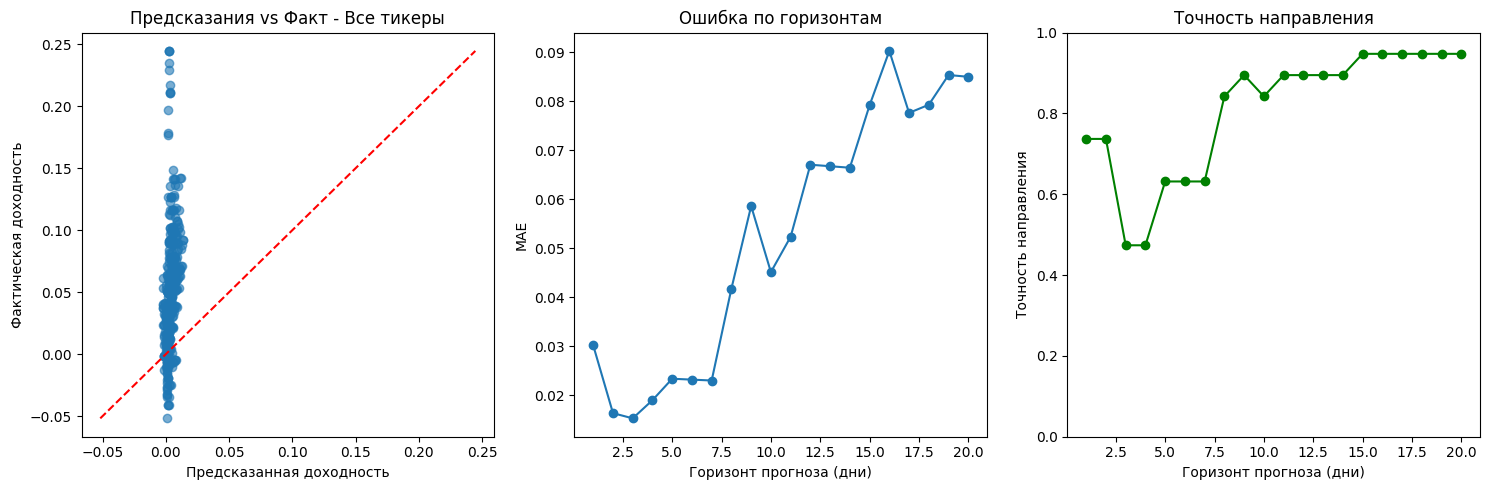

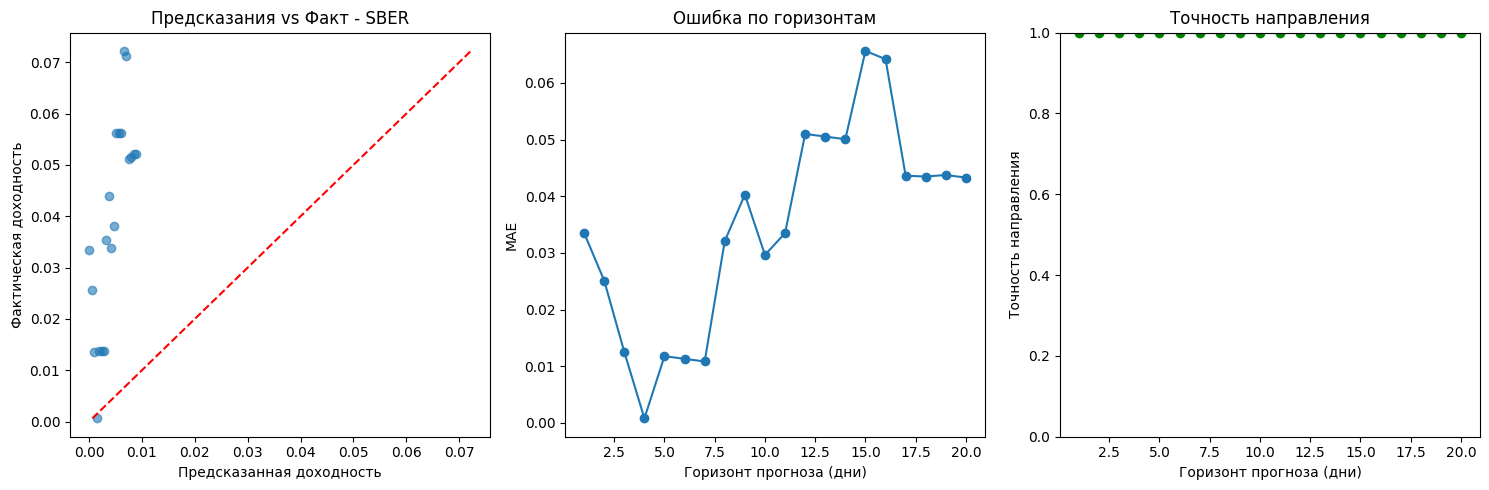

KeyError: 'mse_price'

In [71]:
evaluation_df = prepare_evaluation_data(candles, submission, '2024-09-08')

print_detailed_metrics(evaluation_df)

plot_predictions(evaluation_df)
plot_predictions(evaluation_df, 'SBER')  # для конкретного тикера

best_predictions = evaluation_df.nsmallest(10, 'mse_price')
worst_predictions = evaluation_df.nlargest(10, 'mse_price')